In [1]:
import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')

import gw150814_simulator as gs
from gw150814_simulator import GW150814, defaults, GW150814_Additive
# import module

import torch
import numpy as np
import scipy
import scipy.stats
import pytorch_lightning as pl
from collections import defaultdict
from tqdm import tqdm
import plotfancy as pf
pf.housestyle_rcparams()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

mycolors = ['#77aca2', '#ff004f', '#f98e08']
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')


In [2]:
default = gs.defaults
default['posterior_samples_path'] = '../../mist-base/GW/GW150814_posterior_samples.npz'
default['f_max']=250
gw = gs.GW150814(settings=default)
l = len(gw.generate_time_domain_waveform())
s = 1000
tdw = np.zeros([s,l])
tdn = np.zeros([s,l])

for i in tqdm(range(s)):
    tdw[i] = gw.generate_time_domain_waveform()
    tdn[i] = gw.generate_time_domain_noise()

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 282.70it/s]


In [8]:
correlation_scales = torch.tensor([5]).int()
gw150814_post = torch.tensor(tdw)
gw150814_noise = torch.tensor(tdn)
gw150814_samples = {'mu': gw150814_post, 'noise': gw150814_noise}
simulator = GW150814_Additive(
    gw150814_samples=gw150814_samples, 
    bounds=torch.tensor([1.05]), #1.2341, 0.5696, 0.3403]), 
    dtype=torch.float32,
    correlation_scales = correlation_scales
)
# times = simulator._process(simulator.times)
times = simulator.times
Nbins = simulator.Nbins

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


  0%|                                                   | 0/500 [00:00<?, ?it/s]


ValueError: x and y must have same first dimension, but have shapes (16384,) and (1, 16384)

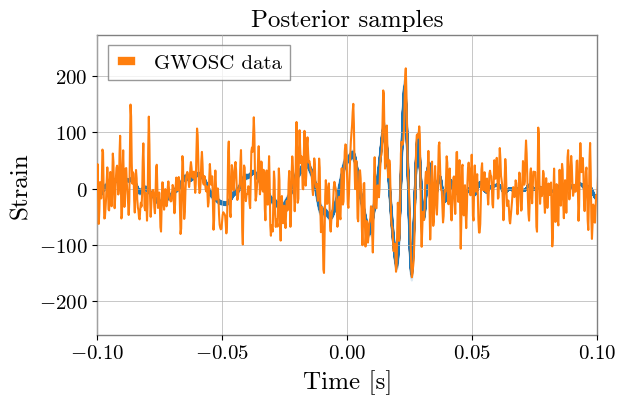

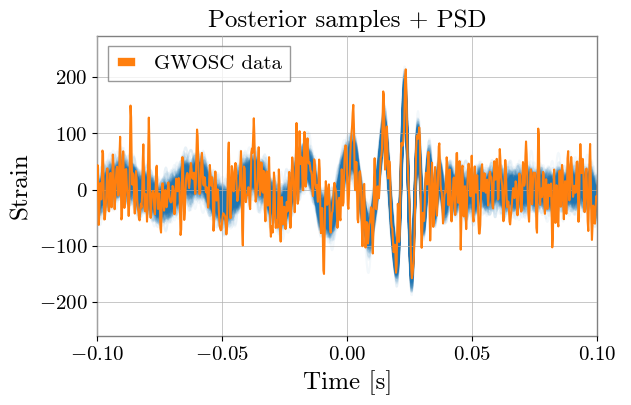

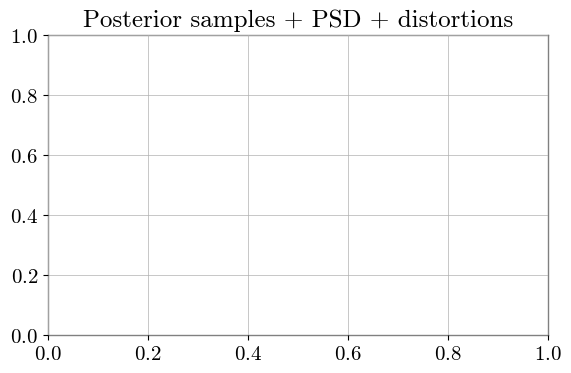

In [19]:
samples = simulator.sample(500)

keys = ['mu','x0','xi',]
titles = ["Posterior samples","Posterior samples + PSD","Posterior samples + PSD + distortions"]
for j in range(3):
    fig,ax = pf.create_plot(size=(5,3))
    ax.set_title(titles[j])
    for i in tqdm(range(500)):
        ax.plot(times, samples[keys[j]][i], color="C0", alpha=0.05)
    ax.plot(simulator.times, np.squeeze(simulator.filter_gwosc_data()), color="C1", zorder=10, label="GWOSC data")
    ax.set_xlim(-0.1, 0.1)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Strain")
    ax.legend();
